<a href="https://colab.research.google.com/github/kwulffert/ULMFiT_Sentiment_Analysis/blob/master/ULMFiT_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis of US airlines tweets using ULMFiT

In this notebook the NLP transfer learning method "Universal Language Model Fine-tuning" (ULMFiT) is applied for sentiment classification of travellers' tweets about their experiences flying with six US airlines.

The work is structured as follows:

* Import libraries
* Data load
* Data exploration
* Text pre-processing
* Universal Language Model Fine-tuning (ULMFiT) application
 * General-domain LM pretraining
 * Target task LM fine-tuning
 * Target task classifier fine-tuning
* Analysis of results
* Conclusions

## Import libraries

In [7]:
! pip install spacymoji &> /dev/null # Install spacymoji for handling of emojis in tweets.

In [8]:
import re                 # for data preprocessing using regular expressions
import string             # for removing punctuation
import collections        # used for count with Counter
import seaborn as sns     # for data visualisation
import spacy              # for data preprocessing
from spacymoji import Emoji # for handling of emojis in tweets 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for visualizing high frequency words 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # to avoid displaying future warnings

import pandas as pd       # for handling dataframes
pd.options.display.max_colwidth = 144 # setting to display the whole content of the tweets (max 144 chars)

In [9]:
from fastai.text import * # fastai library with modules necessary to train and use ULMFiT models.

## Data Load 

The dataset with travellers' tweets about their experiences flying with six US airlines is available on [kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv). 

In [12]:
# Mount google drive with dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
# Load dataset with tweets into a dataframe
folder = os.path.join("/content/gdrive/My Drive/Colab Notebooks" , "model")
path = os.path.join("/content/gdrive/My Drive/Colab Notebooks/data", "Tweets.csv")
df = pd.read_csv(path)

## Data Exploration

In [72]:
# First look at the first 5 rows of the dataset
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I need to take another trip!,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing about it,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


The dataset has 15 columns and 14640 tweets.
<br> There are no null values in the columns text and airline_sentiment which are the columns we will be using for the ULMFit implementation for sentiment analysis. 

In [73]:
# Size of the dataset
df.shape

(14640, 15)

In [74]:
# List column names, count non null values and display type of data in each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [75]:
# Let's define a reduced dataframe with only the columns with the text of the tweets and the label in airline_sentiment 
df_sent = df.copy()
df_sent = df_sent[["airline_sentiment","text"]]
df_sent = df_sent.rename(columns={"airline_sentiment":"label"})
df_sent.head(2)
                      

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.


Let's have a look at how many labels are present in the dataset and how many tweets per label category the dataset has.

In [76]:
# Overview of how many tweets are labelled in which categories
df_sent["label"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: label, dtype: int64

In [77]:
# Overview in percentage:
(100*df_sent["label"].value_counts()/len(df_sent)).round(2)

negative    62.69
neutral     21.17
positive    16.14
Name: label, dtype: float64

The vast majority of reviews is negative covering 62.29% of the available dataset. 
<br>Positive tweets are only 16.14% and neutral tweets 21.17% of the total tweets in the dataset.

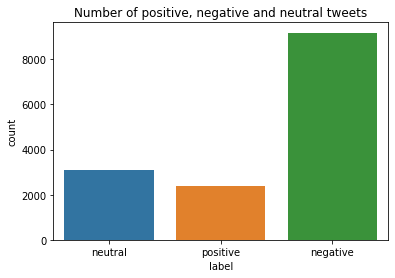

In [78]:
# Visualisation of the  amount of tweets labelled as positive, negative and neutral.
fig = sns.countplot(x = 'label', data = df_sent).set_title("Number of positive, negative and neutral tweets")

## Text pre-processing

Let's have a look at one tweet content.

In [79]:
# For sentiment analysis of the tweet, we need the text only. Let's have a look at one example
df["text"][df["tweet_id"] == 569987622484848640]

62    @VirginAmerica @ladygaga @carrieunderwood all are great , but I have to go with #CarrieUnderwood 😍👌
Name: text, dtype: object

Tweets may contain emojis, handles, tags, spelling errors and informal grammar. 

For text pre-processing we will proceed as follows:
* Remove symbols such as punctuation, currency and digits.
* Translate emojis to a human-readable description of the emoji.
* Remove stopwords.
* Convert text to lower case.

In [14]:
def remove_symbols(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text) # Remove any sequence of numbers
    return text

assert(remove_symbols("!\"#$%&\'()*+,-./:HeLLo;<=>?@[\\]^_`{|}~") == "HeLLo") # Unit test to verify punctuation removal.

In [15]:
nlp = spacy.load('en')
emoji = Emoji(nlp)
nlp.add_pipe(emoji, first=True)

def text_preprocessing(text):
  doc = nlp(text) # Converts text in an nlp object
  result = []
  for token in doc:
    if token._.is_emoji:  # Translate unicode emojis to a human-readable description of the emoji.
      result.append(token._.emoji_desc)    
    elif token.is_stop or token.is_digit or token.is_punct or token.is_currency:  # Removes tokens that are stop words, digits, punctuation and currency symbols.
      continue
    else:
      result.append(token.text.lower()) # Convert text to lower case. 
  return remove_symbols(" ".join(result)) # Removes symbols and digits that are not separated tokens.

test_string = "This is a 12 $ @test? 😻 👍🏿"

assert text_preprocessing(test_string) == "test smiling cat face with hearteyes thumbs up dark skin tone", text_preprocessing(test_string)

Now we apply the function text_preprocessing to the column "text" of our data set which contains the text of the tweets and create a new column called "clean" with the output. 

In [82]:
df_sent["clean"] = df_sent.apply(lambda x: text_preprocessing(x["text"]), axis=1)
df_sent.head(5)

,label,text,clean
0,neutral,@VirginAmerica What @dhepburn said.,virginamerica dhepburn said
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.,virginamerica plus added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!,virginamerica today mean need trip
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",virginamerica aggressive blast obnoxious entertainment guests faces amp little recourse
4,negative,@VirginAmerica and it's a really big bad thing about it,virginamerica big bad thing


### Visualisation of most frequent words

We will use WordCloud to show which words are the most frequent among the different categories of tweets after text processing.
<br>Stopwords are removed using the WordCloud inbuilt list of stopwords. They are removed as they don't add much meaning to a sentence and can be removed without impacting performance.

In [83]:
# Let's keep just the label and cleaned text columns in our dataset.

df_sent = df_sent.drop(labels="text", axis=1)
df_sent.head(3)

,label,clean
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercials experience tacky
2,neutral,virginamerica today mean need trip


In [84]:
# Start with one review:
df_sent_positive = df_sent[df_sent["label"]=="positive"]
df_sent_negative = df_sent[df_sent["label"]=="negative"]
df_sent_neutral = df_sent[df_sent["label"]=="neutral"]
text_all = " ".join(text for text in df_sent.clean)
text_positive = " ".join(text for text in df_sent_positive.clean)
text_negative = " ".join(text for text in df_sent_negative.clean)
text_neutral = " ".join(text for text in df_sent_neutral.clean)

<function matplotlib.pyplot.show>

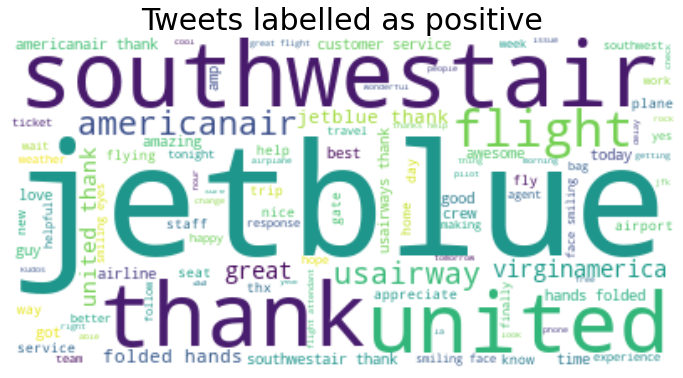

In [85]:
# Create and generate a word cloud image for positive labelled tweets:
wordcloud_positive = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_positive)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Tweets labelled as positive',fontsize=30)
plt.axis('off')
plt.show

The airline most frequently mentioned in positive tweets is Jetblue and words such as "thank", "great", "amazing" are also present in the word cloud image. 

<function matplotlib.pyplot.show>

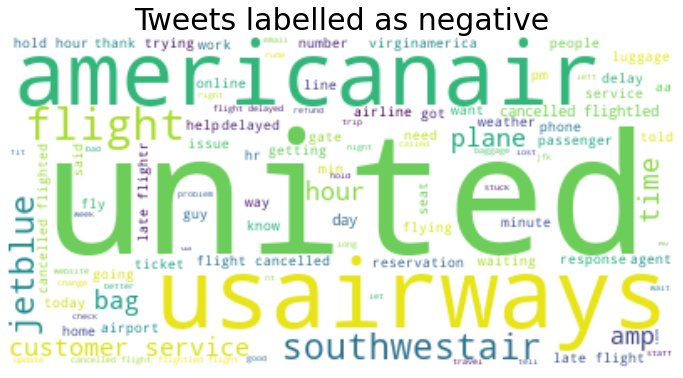

In [86]:
# Create and generate a word cloud image for negative labelled tweets:
wordcloud_negative = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_negative)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Tweets labelled as negative',fontsize=30)
plt.axis('off')
plt.show

The airline most frequently mentioned in negative tweets is United and words such as "bag", "customer service" and "cancelled" are also present in the word cloud image which are usual associated with negative flight experience.

<function matplotlib.pyplot.show>

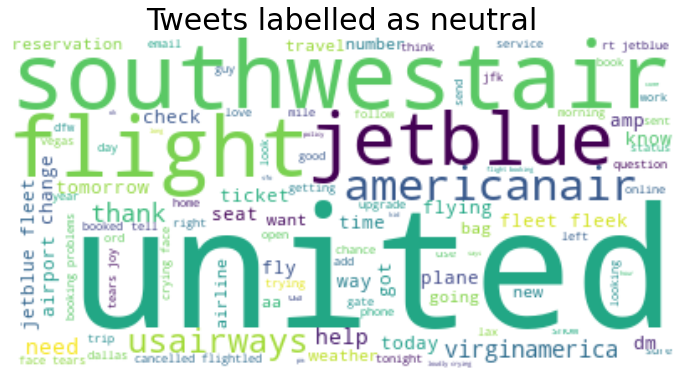

In [87]:
# Create and generate a word cloud image for positive labelled tweets:
wordcloud_neutral = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(text_neutral)
plt.figure(figsize  = (12,12))
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Tweets labelled as neutral',fontsize=30)
plt.axis('off')
plt.show

The word cloud for neutral tweets contains all six airline names and words that could be part of a negative or positive tweet, so it is not that informative as the two previous word clouds.

## Universal Language Model Fine Tunning (ULMFiT) application

ULMFit is a transfer learning method that can be applied to any NLP tasks and introduce techniques. In ULMFit techniques as discriminative fine-tuning, slanted triangular learning rate and gradual unfreezing are used for fine-tuning.   

ULMFiT consists of three stages: 
1. The language model (LM) is trained on a general-domain corpus to capture
general features of the language in different layers. 
2. The full LM is fine-tuned on target task data using
discriminative fine-tuning and slanted triangular learning rates to learn task-specific
features. 
3. The classifier is fine-tuned on the target task using gradual unfreezing, discriminative fine-tuning and slanted triangular learning rates to
preserve low-level representations and adapt high-level ones.

The ULMFit implementation in this notebook is based on [ULMFit's paper ](https://arxiv.org/pdf/1801.06146.pdf) by Jeremy Howard and Sebastian Ruder, the libraries provided by fastai and a general introduction by the ULMFit creators at [fast.ai](http://nlp.fast.ai/classification/2018/05/15/introducing-ulmfit.html).

In order to apply ULMFit for sentiment classification of the US airlines tweets dataset, we will proceed as follows:

* Prepare the data for the language model and the classification model.
* General domain LM pre-training: Use the in fast.ai already available pre-trained model on the pre-processed large subset of English Wikipedia.
* Train and fine-tune a LM to generate US airlines tweets. 
* Build  and fine-tune a sentiment classifier of the US airlines tweets.
* Run tests to assess the sentiment classifier.

### Getting the data ready for modeling

We will split the pre-processed dataset into train (90%) and test (10%) datasets and then proceed to the data preparation for the language model and the class model.

In [89]:
da_train = df_sent.sample(frac = 0.9, random_state= 23)
da_test = df_sent.drop(da_train.index)

In [90]:
# Verify that the distribution of positive, negative and neutral tweets in the train and test dataset is representative in comparison to the original distribution.
da_summary = pd.DataFrame((100*df_sent["label"].value_counts()/len(df_sent)).round(2))
da_summary["train[%]"] = (100*da_train["label"].value_counts()/len(da_train)).round(2)
da_summary["test[%]"] = (100*da_test["label"].value_counts()/len(da_test)).round(2)
da_summary = da_summary.rename(columns = {"label" : "original[%]"})
da_summary

,original[%],train[%],test[%]
negative,62.69,62.88,61.00
neutral,21.17,21.01,22.61
positive,16.14,16.11,16.39


### US airlines tweets generator Language Model

#### *Data preparation for the language model*

We create a TextDataBunch (bind train and validation data in a data object) suitable for training a language model.
All the texts in the datasets are concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

During the creation of the TextDataBunch, tokenization and numericalization on the text is done.


In [234]:
bs = 48 # batch size
data_lm = TextLMDataBunch.from_df(train_df = da_train, valid_df = da_train, path = folder, bs=bs, text_cols = "clean")
data_lm.save('data_lm.pkl')

In [235]:
data_lm = load_data(folder, 'data_lm.pkl', bs=bs)

In [236]:
data_lm.show_batch()

idx,text
0,room night thx helpful customer service rep n xxunk thanked u goodenoughmother xxbos jetblue delayed tpa bdl better safe sorry blue heart lovejetblue xxunk xxunk xxbos united extremely disappointed flight united left crew xxunk stranded rain gate cover left xxunk depart plane xxbos southwestair thank u thank u thank u coming sincerely think happen lt swa thankyou xxbos virginamerica xxunk luv virgin america xxunk xxbos usairways unacceptable going day day
1,hold hours hung cancelled flightled flights running xxunk kids trapped home xxbos virginamerica luggage gone filed paperwork promised email resolution response central luggage xxbos united nice know hours time worth free directtv hear xxunk maintenance xxbos southwestair flight phl fll cancelled flighted flight available sw xxbos united happened afternoon huge xxunk incoming planes sfo delayed hours \n frustrating xxbos jetblue names angel seriously cool truly fantastic service xxbos americanair
2,jetblue gotcha thanks update ready enjoy evening xxbos usairways days hours hold day charge double flights fix worst service xxbos usairways talked reservation xxunk friendly good usair airline fly xxbos united working wc coach good thing bird landed ahead schedule use wc stat xxbos united yes located bag lovely flight outside xxbos usairways got email asking checkin tmrw flight meant book help xxunk xxunk xxbos united following xxbos americanair true
3,xxbos southwestair thank handling glad southwest cares flyers think xxbos americanair cancelled flightled ticket taking months refund waiting xxbos southwestair thx smooth landing today flymidway xxunk u abt weather xxunk xxunk xxbos jetblue lack tv rough literally picked y competitors xxbos usairways citizen fly airline constantly xxunk derrick bussey m crying airplane upset xxbos united perfect thank xxbos americanair board today watched report xxunk twitter proud xxbos virginamerica thanks taking
4,aa refsd xxunk bags bag xxunk aa refsd fix tkts xxunk said fly xxbos virginamerica xxunk dropped track xxunk xxbos usairways enjoying flights far great job today tough thanks making flights comfortable xxbos usairways phone line disconnects queue answered phone line simply disconnects xxbos usairways feet gate phl ground crew xxbos usairways difficult work baggage claims answer phone xxbos americanair answer question maybe provide details clarification xxbos americanair trip cut


In [237]:
# Number of words in the vocabulary data_lm
len(data_lm.vocab.itos)

5416

#### *Language model training and fine-tuning* 

We create a language model learner, it's is creating an RNN using the already prepared language model data and the pre-trained Wikitext103 model provided by fast.ai. 
<br> We will then fine tune the model and test the tweets generated by the trained model.

In [123]:
learn = language_model_learner(data_lm,  arch = AWD_LSTM, pretrained = True, drop_mult=0.3)

In [124]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


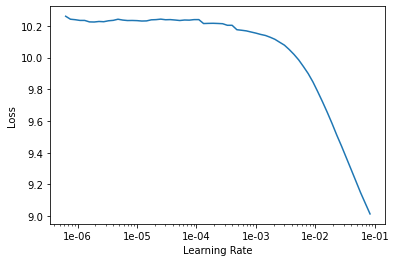

In [125]:
learn.recorder.plot(skip_end=25)

In [126]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,7.084108,5.857353,0.140104,00:16


In [127]:
learn.save('fit_head')

In [128]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [105]:
# Unfreeze the last layer
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.823914,5.456865,0.172254,00:16


In [106]:
# Unfreeze the next layer
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.484447,5.137866,0.196875,00:16


In [107]:
# Unfreeze the next layer 
learn.freeze_to(-3)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.365643,4.988729,0.206570,00:18


In [129]:
# Unfreeze all layers
learn.unfreeze()

In [ ]:
# Run training on unfrozen model for 100 epochs to improve accuracy. On 100th epoch accuracy reaches 0.767664
learn.fit_one_cycle(100, 1e-3, moms=(0.8,0.7));

In [131]:
# Save the model
learn.save('tweet_lm_fine_tuned')

Let's load the tweets generator we just trained and test it to generate a tweet of 10 words.

In [ ]:
learn.load('tweet_lm_fine_tuned');

In [159]:
tweet = "americanair flight is going to be"

In [160]:
learn.predict(tweet, 10, temperature=1.1, min_p=0.01)

'americanair flight is going to be cancelled flightled thanks xxbos united flight cancelled flightled trying home'

The model predicts accurately the next word "cancelled". However, the rest of the test is not meaningful.
<br> We save the model encoder, the part of the language model that understands the sentence rather that the part that predicts the next word.

In [161]:
learn.save_encoder('tweet_lm_fine_tuned_enc')

### Sentiment classifier of US airlines tweets


#### *Data preparation for the classification model*

We create a TextDataBunch suitable for training a classifier.

In [238]:
data_class = TextClasDataBunch.from_df(train_df = da_train, valid_df = da_train, path = folder, bs=bs, vocab=data_lm.train_ds.vocab)
             
data_class.save("data_class.pkl")

In [246]:
# Check that the labels of the dataset are present in the language model's vocabulary.
"positive" and "negative" and "neutral" in data_lm.vocab.itos

True

In [199]:
data_class = load_data(folder, "data_class.pkl", bs=bs)

In [200]:
data_class.show_batch()

text,target
xxbos usairways best airways follow folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands crying face crying face crying face crying face crying face crying face crying face crying face folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded,positive
xxbos usairways best airways follow folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands folded hands,positive
xxbos virginamerica thanks follow \n ourprincess freyasfund usa xxunk \n looking help smiling face with hearteyes \n growing heart xxmaj united xxmaj kingdom growing heart xxmaj united xxmaj states growing heart \n ribbon globe showing xxunk ribbon xxunk,neutral
xxbos jetblue zkatcher face with tears of joy face with tears of joy face with tears of joy face with tears of joy face with tears of joy omg xxunk amp read convo like jetblue point,negative
xxbos usairways grades trip \n \n flight timeliness thumbs down airplane ️ \n cancelled flightations thumbs down grimacing face \n customer service thumbs down pouting face \n flight attendants smiling face with smiling eyes clapping hands,negative


#### *Classifier training and fine-tuning*
We will now create a model to classify the sentiment of the tweets using the already prepared data for the classification model. We will use the AWD_LSTM model with 50% dropout.
<br> We load the encoder from the trained language model, then freeze the classifier and find the learning rate.

In [ ]:
learn = text_classifier_learner(data_class, arch=AWD_LSTM, drop_mult=0.5)

In [203]:
learn.load_encoder('tweet_lm_fine_tuned_enc')
learn.freeze()

In [204]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


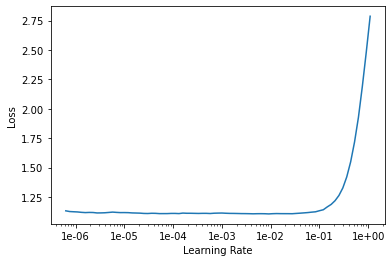

In [187]:
learn.recorder.plot()

In [205]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.691692,0.568332,0.770188,00:14


In [206]:
learn.save('first')

In [207]:
learn.load('first');

We will now fine-tune the classifier by unfreezing layers step by step starting with the last layer.

In [208]:
learn.freeze_to(-1)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.672701,0.565698,0.776943,00:14


In [209]:
learn.save('second')

In [210]:
learn.load('second');

In [211]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.626503,0.514351,0.795765,00:15


In [212]:
learn.save('third')

In [213]:
learn.load('third');

In [214]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.615721,0.454537,0.823543,00:22


In [215]:
learn.save('fourth')

In [217]:
learn.load('fourth');

In [218]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.546704,0.382755,0.857165,00:27


In [219]:
learn.save('fifth')

In [220]:
learn.load('fifth');

In [221]:
learn.freeze_to(-5)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.542503,0.332885,0.882817,00:28


In [ ]:
learn.save('sixth')

In [ ]:
learn.load('sixth');

In [222]:
learn.freeze_to(-6)
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.445567,0.273133,0.903157,00:29


In [223]:
learn.save('seventh')

In [226]:
learn.load('seventh');

After unfreezing and training the last 6 layers, one layer at a time, our classifier has an accuracy of 0.903157.
<br> We now proceed unfreezing all layers and training the whole achieving an accuracy of 0.953628. 

In [227]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.403299,0.243044,0.915528,00:29
1,0.388275,0.193950,0.938525,00:29
2,0.345094,0.157026,0.950592,00:28
3,0.334858,0.145979,0.953628,00:29


In [228]:
learn.save('final_classificator')

In [25]:
learn.load('final_classificator');

NameError: ignored

## Analysis of results

In [309]:
list_classes = learn.data.classes

In [262]:
class_dict = learn.data.c2i

In [20]:
def test_classifier(tweet):
  val = learn.predict(tweet, thresh=0.4)
  classification = list(class_dict.keys())[list(class_dict.values()).index(val[1].item())]
  print("Tweet sentiment: {}".format(classification))
  print("Complete prediction:{}".format(list_classes))
  print(val[2].tolist())
  return 


In [362]:
test_classifier("hello people on a plane")

Tweet sentiment: neutral
Complete prediction:['negative', 'neutral', 'positive']
[0.09862083196640015, 0.6882877349853516, 0.2130914330482483]


In [331]:
test_classifier("I had the worst flight ever")

Tweet sentiment: negative
Complete prediction:['negative', 'neutral', 'positive']
[0.9722210168838501, 0.01264268346130848, 0.015136203728616238]


In [366]:
test_classifier("Customer service was amazing")

Tweet sentiment: positive
Complete prediction:['negative', 'neutral', 'positive']
[0.21232794225215912, 0.0008086509769782424, 0.7868634462356567]


### Test with tweets from the web

In [18]:
test_tweet = "👏 #JetBlue will be carbon neutral on all domestic flights by July 2020 #CarbonNeutral #travel"

In [ ]:
test_tweet = text_preprocessing(test_tweet)
test_classifier(test_tweet)

In [ ]:
test_tweet = "Why would ANYONE fly on #AmericanAirlines ?? I work in the travel industry and I am constantly hearing horror stories from people that have flown on #AmericanAirlines  👀 👀 👀"


In [ ]:
test_tweet = text_preprocessing(test_tweet)
test_classifier(test_tweet)

## Conclusions

Transfer learning in NLP using ULMFit provides a powerful foundation for custom NLP tasks as the sentiment classification of US airline tweets implemented in this project.

<br>In this project, the general pre-trained model on the Wikitext301 dataset was used and even if the grammar, topics and length of text in wikipedia differs significantly from the unstructured, colloquial and short language in tweets, the trained model has a high accuracy (over 0.95) and performs well in tests using tweets from 2020 (note that the tweets dataset use din this projects dates from 2015).

<br>The classifier could be improved by doing extensive fine-tuning using discriminative fine-tuning, slanted triangular learning rate. 

<br>A future work improvement would be to use a pre-trained model on an extensive tweets dataset as basis for the knowledge transfer, in this way, the data pre-processing part for cleaning data and translating emojis would not be needed and the model could learn to classify sentiments from the unprocessed tweets. 